In [30]:
import numpy as np
from scipy import stats,fftpack
from tensorflow.keras.utils import to_categorical
from stochastic import diffusion, continuous
from scipy.optimize import curve_fit
import scipy.io

In [31]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [32]:
def Sub_mixing(x0, n, dt, scales, out=None):
    x0 = np.asarray(x0)
    # generate a sample of n numbers from a normal distribution.
    r = stats.norm.rvs(size=x0.shape + (n,), scale=np.sqrt(dt))
    r = r*scales
    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)
    # Compute Brownian motion by forming the cumulative sum of random samples. 
    np.cumsum(r, axis=-1, out=out)
    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

def Mixing(N=1000,T=50,deltas = [1], rate = .1):
    x = np.empty((2,N+1))
    x[:,0] = 0.0

    jumps = np.random.poisson(lam = rate*T)
    jumptimes = np.random.rand(jumps)*N
    jumptimes.sort()
    dc = np.empty(jumps+1)
    dc[0] = np.random.choice(deltas)
    for i, element in enumerate(dc[:-1]):
        temp = deltas[:]  # fastest way to copy
        if len(temp) > 1:
            temp.remove(element)
        dc[i+1] = np.random.choice(temp)

    scales = np.ones(N)*dc[0]

    prev = 0
    succ = None

    for index, jump in enumerate(jumptimes):
        if prev <= N:
            scales[prev:int(jump // 1 + 1)] = dc[index]
            if jump + 1 <= N:
                scales[int(jump // 1 + 1)] = dc[index] * (jump % 1) + dc[index+1] * (1 - jump % 1)
        prev = int(jump // 1 + 2)

    Sub_mixing(x[:,0], N, T/N, scales, out=x[:,1:])

    out1 = x[0]
    out2 = x[1]

    return out1,out2, jumps

In [33]:
'''
Generator functions for neural network training per Keras specifications
input for all functions is as follows:
    
input: 
   - batch size
   - steps: total number of steps in trajectory (list) 
   - T: final time (list)
   - sigma: Standard deviation of localization noise (std of a fixed cell/bead)
'''

# Randomly generate trajectories of different diffusion models for training of the 
# classification network
    
def generate(batchsize=32,steps=1000,T=15,sigma=0.1):
    while True:
        # randomly choose a set of trajectory-length and final-time. This is intended
        # to increase variability in simuation conditions.
        T1 = np.random.choice(T,size=1).item()
        out = np.zeros([batchsize,steps-1,1])
        label = np.zeros([batchsize,1])
#         weight = np.zeros(batchsize)
        for i in range(batchsize):
            # randomly select diffusion model to simulate for this iteration
            constants = np.random.choice([1,2,3])
            dcs = np.random.choice([1,5,10], constants, replace=False)
#             dcs = np.random.uniform(low = 0, high = 20, size = constants)
            x,y,jumps = Mixing(N=steps,T=T1,deltas= dcs.tolist(), rate = .1) 
            label[i,0] = jumps + 1
#             weight[i] =  1/stats.poisson.pmf(jumps, mu = .1*T)
            noise = np.sqrt(sigma)*np.random.randn(1,steps)
            x1 = np.reshape(x,[1,len(x)])
            x1 = x1-np.mean(x1)
            x_n = x1[0,:steps]+noise
            dx = np.diff(x_n)
            out[i,:,0] = dx
       
#         label = to_categorical(label)

        yield out,label,[None]


In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input,GlobalMaxPooling1D,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [35]:
batchsize = 32
T = 100 # this provides another layer of stochasticity to make the network more robust
steps = 1000 # number of steps to generate
initializer = 'he_normal'
f = 32
sigma = 0.1

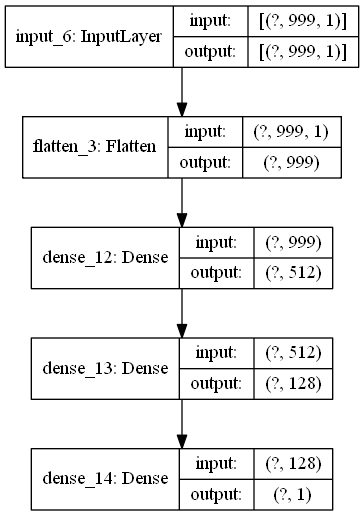

In [36]:
inputs = Input((steps-1,1))
x = keras.layers.Flatten()(inputs)
x1 = Conv1D(f,4,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv1D(f,4,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(f,4,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = BatchNormalization()(x1)
x1 = GlobalMaxPooling1D()(x1)


x2 = Conv1D(f,2,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x2 = BatchNormalization()(x2)
x2 = Conv1D(f,2,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = BatchNormalization()(x2)
x2 = Conv1D(f,2,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = BatchNormalization()(x2)
x2 = GlobalMaxPooling1D()(x2)


x3 = Conv1D(f,3,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x3 = BatchNormalization()(x3)
x3 = Conv1D(f,3,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = BatchNormalization()(x3)
x3 = Conv1D(f,3,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = BatchNormalization()(x3)
x3 = GlobalMaxPooling1D()(x3)


x4 = Conv1D(f,10,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x4 = BatchNormalization()(x4)
x4 = Conv1D(f,10,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = BatchNormalization()(x4)
x4 = Conv1D(f,10,dilation_rate=8,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = BatchNormalization()(x4)
x4 = GlobalMaxPooling1D()(x4)


x5 = Conv1D(f,20,padding='same',activation='relu',kernel_initializer=initializer)(inputs)
x5 = BatchNormalization()(x5)
x5 = GlobalMaxPooling1D()(x5)


con = concatenate([x1,x2,x3,x4,x5])
dense = Dense(512,activation='relu')(con)
dense = Dense(128,activation='relu')(dense)
dense2 = Dense(1,activation='relu')(dense)
model = Model(inputs=inputs, outputs=dense2)

optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='MAPE',metrics=['MAPE'])
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [23]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        min_delta=1e-4
    ),
#     ReduceLROnPlateau(
#         monitor='MAPE',
#         factor=0.1,
#         patience=4,
#         verbose=1,
#         min_lr=1e-9
#     ),
    ModelCheckpoint(
        filepath='new_class_model.h5',
        monitor='MAPE',
        save_best_only=True,
        mode='min',
        save_weights_only=False
    )
]

In [29]:
gen = generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma)

history = model.fit(gen,
        steps_per_epoch=100,
        epochs=100,
        callbacks=callbacks,
        validation_data=generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma),
        validation_steps=5)

Train for 100 steps, validate for 5 steps
Epoch 1/100
100/100 [==============================] - 2s 20ms/step - loss: 52.0331 - MAPE: 52.0331 - val_loss: 42.0695 - val_MAPE: 42.0695
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - loss: 50.5389 - MAPE: 50.5389 - val_loss: 52.0864 - val_MAPE: 52.0864
Epoch 3/100
100/100 [==============================] - 2s 19ms/step - loss: 49.8945 - MAPE: 49.8945 - val_loss: 52.2742 - val_MAPE: 52.2742
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 52.8367 - MAPE: 52.8367 - val_loss: 50.9505 - val_MAPE: 50.9505
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - loss: 52.8705 - MAPE: 52.8705 - val_loss: 51.8441 - val_MAPE: 51.8441
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 50.8701 - MAPE: 50.8701 - val_loss: 43.9532 - val_MAPE: 43.9532
Epoch 7/100
100/100 [==============================] - 2s 19ms/step - loss: 51.3944 - MAPE: 51.3944 - val_loss: 45.837

In [25]:
gen = generate(batchsize = 500)
next(gen)

(array([[[ 0.18881597],
         [ 0.40153746],
         [-0.73979016],
         ...,
         [ 0.36983908],
         [-0.33688212],
         [ 0.4842098 ]],
 
        [[ 0.8087192 ],
         [-0.71347549],
         [-0.9084313 ],
         ...,
         [-1.25234843],
         [ 1.29687785],
         [ 0.32512949]],
 
        [[-0.39368835],
         [-0.36361519],
         [ 0.38951984],
         ...,
         [-1.09261523],
         [ 1.25960453],
         [ 0.04463184]],
 
        ...,
 
        [[-0.01050317],
         [ 0.13579176],
         [ 0.5897235 ],
         ...,
         [ 0.11184396],
         [ 1.07410315],
         [-0.16549032]],
 
        [[ 0.40931137],
         [-0.64343492],
         [-0.58698687],
         ...,
         [ 0.01832577],
         [ 0.18332526],
         [ 0.12507944]],
 
        [[-0.71868281],
         [ 0.79811596],
         [ 0.02922015],
         ...,
         [ 0.25083471],
         [-0.4731737 ],
         [ 0.23209604]]]),
 array([[1.],
     

In [28]:
model = keras.models.load_model('new_class_model.h5')
model.evaluate(gen, steps = 50)

 1/50 [..............................] - ETA: 6s

InvalidArgumentError:  Input to reshape is a tensor with 499500 values, but the requested shape requires a multiple of 499
	 [[node model_3/flatten_2/Reshape (defined at <ipython-input-28-7fbbd01dbe90>:2) ]] [Op:__inference_distributed_function_12457]

Function call stack:
distributed_function


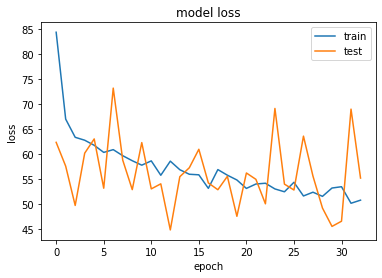

In [15]:
from matplotlib import pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
test, labels = next(gen)

predictions = model.predict(test)
plt.scatter(
    y = labels,
    x = predictions,
    s = .1
)
# plt.legend(loc = 'upper right')
plt.title('Model predictions')
plt.ylabel('Mode switches')
plt.xlabel('Mode Switches - predicted')
plt.show()

In [ ]:
np.shape(labels)

In [ ]:
model.evaluate(gen, steps = 50)

In [ ]:
model.evaluate(gen, steps = 50)

In [ ]:
plt.hist(predictions)